<a href="https://colab.research.google.com/github/Aleena24/real-image-SRGAN/blob/main/research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np

In [ ]:
image_path = '/content/drive/MyDrive/research_dataset/BSD100'

#Image Preprocessing

In [ ]:
def load_images(image_dir, image_size):
    images = []
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img = cv2.imread(os.path.join(image_dir, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, (image_size, image_size))  # Resize to desired size
            images.append(img)
    return images

In [ ]:
image_size = 256

In [ ]:
images = load_images(image_path,  image_size)

<function matplotlib.pyplot.show(close=None, block=None)>

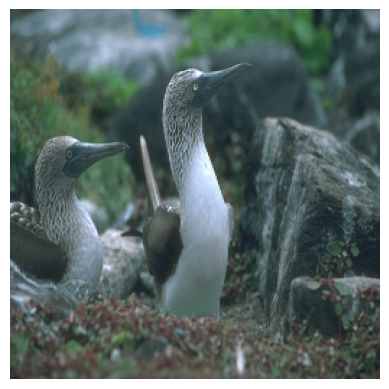

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(images[10])
plt.axis('off')
plt.show

# Generator Network

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_generator(input_shape=(256, 256, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Downsampling layers
    for filters in [128, 256]:
        x = layers.Conv2D(filters, kernel_size=3, strides=2, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

    # Bottleneck
    for _ in range(6):
        residual = x

        x = layers.Conv2D(256, kernel_size=3, strides=1, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

        x = layers.Conv2D(256, kernel_size=3, strides=1, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.add([x, residual])
        x = layers.ReLU()(x)

    # Upsampling layers
    for filters in [128, 64]:
        x = layers.Conv2DTranspose(filters, kernel_size=3, strides=2, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

    # Output layer
    outputs = layers.Conv2DTranspose(3, kernel_size=3, strides=1, padding='same', activation='sigmoid')(x)

    # Define model
    model = Model(inputs, outputs, name='generator')

    return model

# Create an instance of the Generator
generator = build_generator()

# Display the model summary
generator.summary()


#Discriminator Network

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_discriminator(input_shape=(256, 256, 3)):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    # Flatten layer
    model.add(layers.Flatten())

    # Dense layer
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

# Example usage:
discriminator = build_discriminator()
discriminator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 batch_normalization_17 (Ba  (None, 64, 64, 128)       512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                        

#Loss function

In [ ]:
import tensorflow as tf

def generator_loss(fake_output):
    """
    Generator loss function.
    """
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(tf.ones_like(fake_output), fake_output))

def discriminator_loss(real_output, fake_output):
    """
    Discriminator loss function.
    """
    real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(tf.ones_like(real_output), real_output))
    fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(tf.zeros_like(fake_output), fake_output))
    total_loss = real_loss + fake_loss
    return total_loss


#Compile

In [ ]:
# Reshape the input noise vector to match the expected input shape of the generator
reshaped_input = tf.keras.layers.Reshape((256, 256, 3))(gan_input)

# Pass the reshaped input to the generator
generated_image = generator(reshaped_input)

# Define the GAN by connecting the generator and discriminator
gan_input = tf.keras.Input(shape=input_shape)
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)
gan = tf.keras.Model(gan_input, [gan_output, generated_image])


NameError: name 'gan_input' is not defined

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanAbsoluteError

# Compile the discriminator
discriminator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
                      loss=BinaryCrossentropy(),
                      metrics=['accuracy'])

# Make the discriminator untrainable when training the generator
discriminator.trainable = False

# Compile the combined model (generator and discriminator)
gan.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
            loss=[BinaryCrossentropy(), MeanAbsoluteError()],
            loss_weights=[1, 100])  # Adjust the weight for content loss if needed


# Training